# Circuit learning module: Lambeq manually with SPSA and JAX

This module performs the optimization of the parametrized circuit manually compared to Lambeq's automatic QuantumTrainer class. I created this because I wanted to have more control over the optimization process and debug it better. The code is based on the workflow presented in https://github.com/CQCL/Quanthoven.

In [1]:
import warnings
import json
import os
import sys
import glob
from math import ceil
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
import numpy
import pickle
import matplotlib.pyplot as plt

import jax
from jax import jit
from noisyopt import minimizeSPSA, minimizeCompass

from discopy.quantum import Circuit
from discopy.tensor import Tensor
from discopy.utils import loads
#from pytket.extensions.qiskit import AerBackend
#from pytket.extensions.qulacs import QulacsBackend
#from pytket.extensions.cirq import CirqStateSampleBackend
backend = None

from utils import *
#from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

warnings.filterwarnings('ignore')
this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"

SEED = 0

# This avoids TracerArrayConversionError from jax
Tensor.np = np

rng = numpy.random.default_rng(SEED)
numpy.random.seed(SEED)

## Read circuit data

We read the circuits from the pickled files. Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [2]:
# Select workload
#workload = "execution_time"
workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 2
layers = 1
single_qubit_params = 3
n_wire_count = 1

loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//" + workload_size + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//" + workload_size + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels = create_labeled_classes(training_data, classification, workload)
test_data_labels = create_labeled_classes(test_data, classification, workload)
validation_data_labels = create_labeled_classes(validation_data, classification, workload)

## Model

In [5]:
def make_pred_fn(circuits):
    # In the case we want to use other backends. 
    # Currently does not work properly.
    if backend:
        compiled_circuits1 = backend.get_compiled_circuits([c.to_tk() for c in circuits])
        circuits = [Circuit.from_tk(c) for c in compiled_circuits1]
        
    circuit_fns = [c.lambdify(*parameters) for c in circuits]
    
    def predict(params):
        outputs = Circuit.eval(*(c(*params) for c in circuit_fns), backend = backend)
        res = []
        
        for output in outputs:
            predictions = np.abs(output.array) + 1e-9
            ratio = predictions / predictions.sum()
            res.append(ratio)
            
        return np.array(res)
    return predict

## Loss function and evaluation

In [6]:
def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)
        #print(predictions, labels)
        
        cost = loss(predictions, labels) #-np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        accuracy = acc(predictions, labels) #np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(accuracy)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies

## Minimization with noisyopt

In [7]:
def initialize_parameters(old_params, old_values, new_params):
    new_values = list(numpy.array(rng.random(len(new_params))))
    old_param_dict = {}
    for p, v in zip(old_params, old_values):
        old_param_dict[p] = v
        
    parameters = sorted(set(old_params + new_params), key=default_sort_key)
    values = []
    for p in parameters:
        if p in old_param_dict:
            values.append(old_param_dict[p])
        else:
            values.append(new_values.pop())
            
    return parameters, np.array(values)

In [8]:
EPOCHS = 10000
initial_number_of_circuits = 10
syms = {}
limit = False
all_training_keys = list(training_circuits.keys())
initial_circuit_keys = all_training_keys[:initial_number_of_circuits + 1]
current_training_circuits = {}
result_file = workload + "_" + workload_size + "_noisyopt_3_" + str(classification) + "_" + str(layers) + "_" + str(single_qubit_params)

for k in initial_circuit_keys:
    current_training_circuits[k] = training_circuits[k]
    
syms = get_symbols(current_training_circuits)
parameters = sorted(syms, key=default_sort_key)
if initial_number_of_circuits > 10 and os.path.exists("points//" + result_file + ".npz"):
    with open("points//" + result_file + ".npz", "rb") as f:
        print("Loading parameters from file " + result_file)
        npzfile = np.load(f)
        init_params_spsa = npzfile['arr_0']
else:
    print("Initializing new parameters")
    init_params_spsa = np.array(rng.random(len(parameters)))
result = None
run = 0

Initializing new parameters


Progress:  0.022
Number of training circuits: 11   Number of validation circuits: 42   Number of test circuits: 44   Number of parameters in model: 166


Epoch: 200   train/loss: 1.4219   valid/loss: 21.1407   train/acc: 0.8182   valid/acc: 0.2619
Epoch: 400   train/loss: 1.1578   valid/loss: 20.8305   train/acc: 0.9091   valid/acc: 0.2381
Epoch: 600   train/loss: 1.0772   valid/loss: 22.0106   train/acc: 1.0   valid/acc: 0.2619
Epoch: 800   train/loss: 0.7473   valid/loss: 21.3529   train/acc: 1.0   valid/acc: 0.2857
Epoch: 1000   train/loss: 0.7238   valid/loss: 22.5674   train/acc: 1.0   valid/acc: 0.2381
Epoch: 1200   train/loss: 0.7114   valid/loss: 22.9384   train/acc: 1.0   valid/acc: 0.2619
Epoch: 1400   train/loss: 0.6858   valid/loss: 24.3104   train/acc: 1.0   valid/acc: 0.2143
Epoch: 1600   train/loss: 0.6694   valid/loss: 25.6945   train/acc: 1.0   valid/acc: 0.2143
Epoch: 1800   train/loss: 0.6339   valid/loss: 25.5702   train/acc: 1.0   valid/acc: 0.2619
Epoch: 2000   train/loss: 0.5851   valid/loss: 26.847   train/acc: 1.0   valid/acc: 0.2143
Epoch: 2200   train/loss: 0.5591   valid/loss: 26.1445   train/acc: 1.0   valid

Test accuracy: 0.25
Progress:  0.025
Number of training circuits: 11   Number of validation circuits: 42   Number of test circuits: 44   Number of parameters in model: 166
Progress:  0.027
Number of training circuits: 12   Number of validation circuits: 42   Number of test circuits: 44   Number of parameters in model: 166
Progress:  0.029
Number of training circuits: 13   Number of validation circuits: 48   Number of test circuits: 50   Number of parameters in model: 183
Progress:  0.031
Number of training circuits: 14   Number of validation circuits: 65   Number of test circuits: 62   Number of parameters in model: 186
Progress:  0.033
Number of training circuits: 15   Number of validation circuits: 65   Number of test circuits: 62   Number of parameters in model: 186
Progress:  0.036
Number of training circuits: 16   Number of validation circuits: 68   Number of test circuits: 65   Number of parameters in model: 189
Progress:  0.038
Number of training circuits: 17   Number of validat

Epoch: 200   train/loss: 8.644   valid/loss: 34.1298   train/acc: 0.4138   valid/acc: 0.2727
Epoch: 400   train/loss: 7.6202   valid/loss: 34.6575   train/acc: 0.4483   valid/acc: 0.2841
Epoch: 600   train/loss: 6.7487   valid/loss: 39.2695   train/acc: 0.5517   valid/acc: 0.1818
Epoch: 800   train/loss: 6.3677   valid/loss: 38.9195   train/acc: 0.5517   valid/acc: 0.2727
Epoch: 1000   train/loss: 5.6212   valid/loss: 40.4348   train/acc: 0.5862   valid/acc: 0.2273
Epoch: 1200   train/loss: 5.3932   valid/loss: 42.8589   train/acc: 0.6207   valid/acc: 0.25
Epoch: 1400   train/loss: 5.1081   valid/loss: 40.4918   train/acc: 0.6897   valid/acc: 0.2386
Epoch: 1600   train/loss: 5.1517   valid/loss: 41.6084   train/acc: 0.6552   valid/acc: 0.2386
Epoch: 1800   train/loss: 4.8978   valid/loss: 44.7775   train/acc: 0.6897   valid/acc: 0.25
Epoch: 2000   train/loss: 4.8142   valid/loss: 44.8039   train/acc: 0.6897   valid/acc: 0.2614
Epoch: 2200   train/loss: 4.5729   valid/loss: 45.0735   tr

Test accuracy: 0.26436781609195403
Progress:  0.067
Number of training circuits: 30   Number of validation circuits: 91   Number of test circuits: 89   Number of parameters in model: 216
Progress:  0.069
Number of training circuits: 31   Number of validation circuits: 91   Number of test circuits: 89   Number of parameters in model: 216
Progress:  0.071
Number of training circuits: 32   Number of validation circuits: 91   Number of test circuits: 89   Number of parameters in model: 216
Progress:  0.074
Number of training circuits: 33   Number of validation circuits: 91   Number of test circuits: 89   Number of parameters in model: 216
Progress:  0.076
Number of training circuits: 34   Number of validation circuits: 91   Number of test circuits: 89   Number of parameters in model: 216
Progress:  0.078
Number of training circuits: 35   Number of validation circuits: 92   Number of test circuits: 93   Number of parameters in model: 222
Progress:  0.08
Number of training circuits: 36   Num

Epoch: 200   train/loss: 12.9716   valid/loss: 36.0724   train/acc: 0.5102   valid/acc: 0.2323
Epoch: 400   train/loss: 11.9412   valid/loss: 35.5238   train/acc: 0.6531   valid/acc: 0.3232
Epoch: 600   train/loss: 10.3953   valid/loss: 40.604   train/acc: 0.6735   valid/acc: 0.3535
Epoch: 800   train/loss: 9.8799   valid/loss: 38.4149   train/acc: 0.6735   valid/acc: 0.3434
Epoch: 1000   train/loss: 9.3381   valid/loss: 41.1793   train/acc: 0.6531   valid/acc: 0.3131
Epoch: 1200   train/loss: 8.9545   valid/loss: 39.2181   train/acc: 0.6939   valid/acc: 0.3333
Epoch: 1400   train/loss: 8.2592   valid/loss: 40.4201   train/acc: 0.7959   valid/acc: 0.3131
Epoch: 1600   train/loss: 8.2446   valid/loss: 39.5923   train/acc: 0.7755   valid/acc: 0.3333
Epoch: 1800   train/loss: 8.1093   valid/loss: 42.2815   train/acc: 0.7551   valid/acc: 0.3232
Epoch: 2000   train/loss: 8.1078   valid/loss: 39.821   train/acc: 0.7755   valid/acc: 0.3636
Epoch: 2200   train/loss: 7.8628   valid/loss: 39.976

Test accuracy: 0.33663366336633666
Progress:  0.112
Number of training circuits: 50   Number of validation circuits: 99   Number of test circuits: 101   Number of parameters in model: 228
Progress:  0.114
Number of training circuits: 51   Number of validation circuits: 99   Number of test circuits: 101   Number of parameters in model: 228
Progress:  0.116
Number of training circuits: 52   Number of validation circuits: 99   Number of test circuits: 101   Number of parameters in model: 228
Progress:  0.118
Number of training circuits: 53   Number of validation circuits: 99   Number of test circuits: 101   Number of parameters in model: 228
Progress:  0.121
Number of training circuits: 54   Number of validation circuits: 99   Number of test circuits: 101   Number of parameters in model: 228
Progress:  0.123
Number of training circuits: 55   Number of validation circuits: 99   Number of test circuits: 101   Number of parameters in model: 228
Progress:  0.125
Number of training circuits: 5

Epoch: 200   train/loss: 22.6701   valid/loss: 36.7244   train/acc: 0.3478   valid/acc: 0.2427
Epoch: 400   train/loss: 21.1774   valid/loss: 37.093   train/acc: 0.3768   valid/acc: 0.2524
Epoch: 600   train/loss: 19.9876   valid/loss: 39.1595   train/acc: 0.4638   valid/acc: 0.2621
Epoch: 800   train/loss: 18.2001   valid/loss: 40.2365   train/acc: 0.5652   valid/acc: 0.2718
Epoch: 1000   train/loss: 16.7125   valid/loss: 40.3723   train/acc: 0.6087   valid/acc: 0.2718
Epoch: 1200   train/loss: 15.6661   valid/loss: 40.4084   train/acc: 0.5652   valid/acc: 0.3398
Epoch: 1400   train/loss: 15.268   valid/loss: 43.2805   train/acc: 0.6232   valid/acc: 0.301
Epoch: 1600   train/loss: 14.7959   valid/loss: 42.1878   train/acc: 0.6232   valid/acc: 0.301
Epoch: 1800   train/loss: 14.4233   valid/loss: 41.6789   train/acc: 0.5942   valid/acc: 0.2621
Epoch: 2000   train/loss: 14.1845   valid/loss: 40.0547   train/acc: 0.6522   valid/acc: 0.3204
Epoch: 2200   train/loss: 14.0884   valid/loss: 

Test accuracy: 0.42857142857142855
Progress:  0.156
Number of training circuits: 70   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 231
Progress:  0.158
Number of training circuits: 71   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 231
Progress:  0.161
Number of training circuits: 72   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 231
Progress:  0.163
Number of training circuits: 73   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 231
Progress:  0.165
Number of training circuits: 74   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 231
Progress:  0.167
Number of training circuits: 75   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 231
Progress:  0.17
Number of training circui

Epoch: 200   train/loss: 26.3687   valid/loss: 37.9377   train/acc: 0.4432   valid/acc: 0.233
Epoch: 400   train/loss: 27.9038   valid/loss: 35.2855   train/acc: 0.3636   valid/acc: 0.3204
Epoch: 600   train/loss: 24.1281   valid/loss: 37.3537   train/acc: 0.4318   valid/acc: 0.3107
Epoch: 800   train/loss: 26.3597   valid/loss: 37.2097   train/acc: 0.3636   valid/acc: 0.2136
Epoch: 1000   train/loss: 22.9851   valid/loss: 36.9118   train/acc: 0.5341   valid/acc: 0.2233
Epoch: 1200   train/loss: 22.0439   valid/loss: 36.9483   train/acc: 0.5568   valid/acc: 0.3204
Epoch: 1400   train/loss: 21.3338   valid/loss: 39.2047   train/acc: 0.5795   valid/acc: 0.3107
Epoch: 1600   train/loss: 21.0942   valid/loss: 36.908   train/acc: 0.5795   valid/acc: 0.3495
Epoch: 1800   train/loss: 20.6717   valid/loss: 42.1638   train/acc: 0.6136   valid/acc: 0.3204
Epoch: 2000   train/loss: 19.9601   valid/loss: 40.7881   train/acc: 0.6364   valid/acc: 0.3398
Epoch: 2200   train/loss: 19.774   valid/loss:

Test accuracy: 0.3333333333333333
Progress:  0.201
Number of training circuits: 89   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 231
Progress:  0.203
Number of training circuits: 90   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 231
Progress:  0.205
Number of training circuits: 91   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 231
Progress:  0.208
Number of training circuits: 92   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 231
Progress:  0.21
Number of training circuits: 93   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 231
Progress:  0.212
Number of training circuits: 94   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 231
Progress:  0.214
Number of training circuit

Epoch: 200   train/loss: 35.6321   valid/loss: 37.1201   train/acc: 0.3364   valid/acc: 0.301
Epoch: 400   train/loss: 34.1638   valid/loss: 36.7379   train/acc: 0.3645   valid/acc: 0.2524
Epoch: 600   train/loss: 35.1867   valid/loss: 37.2878   train/acc: 0.2804   valid/acc: 0.2718
Epoch: 800   train/loss: 33.6089   valid/loss: 36.7128   train/acc: 0.3645   valid/acc: 0.3301
Epoch: 1000   train/loss: 32.7384   valid/loss: 38.6477   train/acc: 0.4206   valid/acc: 0.3301
Epoch: 1200   train/loss: 31.4466   valid/loss: 36.6431   train/acc: 0.4393   valid/acc: 0.3981
Epoch: 1400   train/loss: 31.3029   valid/loss: 36.9448   train/acc: 0.4673   valid/acc: 0.3495
Epoch: 1600   train/loss: 30.7904   valid/loss: 37.3414   train/acc: 0.4299   valid/acc: 0.3981
Epoch: 1800   train/loss: 28.7052   valid/loss: 38.3956   train/acc: 0.5701   valid/acc: 0.4078
Epoch: 2000   train/loss: 27.6718   valid/loss: 39.0252   train/acc: 0.5607   valid/acc: 0.4078
Epoch: 2200   train/loss: 28.2145   valid/los

Test accuracy: 0.4095238095238095
Progress:  0.246
Number of training circuits: 108   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 234
Progress:  0.248
Number of training circuits: 109   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 234
Progress:  0.25
Number of training circuits: 110   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 234
Progress:  0.252
Number of training circuits: 111   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 234
Progress:  0.254
Number of training circuits: 112   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 234
Progress:  0.257
Number of training circuits: 113   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 234
Progress:  0.259
Number of training c

Epoch: 200   train/loss: 43.2241   valid/loss: 36.4179   train/acc: 0.2362   valid/acc: 0.2476
Epoch: 400   train/loss: 43.678   valid/loss: 39.0308   train/acc: 0.3465   valid/acc: 0.2286
Epoch: 600   train/loss: 39.9187   valid/loss: 36.8745   train/acc: 0.4173   valid/acc: 0.3048
Epoch: 800   train/loss: 36.7678   valid/loss: 35.7454   train/acc: 0.4803   valid/acc: 0.2762
Epoch: 1000   train/loss: 36.4163   valid/loss: 34.7429   train/acc: 0.4409   valid/acc: 0.419
Epoch: 1200   train/loss: 37.1393   valid/loss: 35.1381   train/acc: 0.4724   valid/acc: 0.3238
Epoch: 1400   train/loss: 35.9649   valid/loss: 36.0601   train/acc: 0.4409   valid/acc: 0.3524
Epoch: 1600   train/loss: 36.2711   valid/loss: 36.1315   train/acc: 0.5276   valid/acc: 0.2762
Epoch: 1800   train/loss: 36.6769   valid/loss: 35.8016   train/acc: 0.4803   valid/acc: 0.4095
Epoch: 2000   train/loss: 34.0334   valid/loss: 39.2177   train/acc: 0.5118   valid/acc: 0.3333
Epoch: 2200   train/loss: 33.5583   valid/loss

Test accuracy: 0.46226415094339623
Progress:  0.29
Number of training circuits: 128   Number of validation circuits: 105   Number of test circuits: 106   Number of parameters in model: 246
Progress:  0.292
Number of training circuits: 129   Number of validation circuits: 105   Number of test circuits: 106   Number of parameters in model: 246
Progress:  0.295
Number of training circuits: 130   Number of validation circuits: 105   Number of test circuits: 106   Number of parameters in model: 246
Progress:  0.297
Number of training circuits: 131   Number of validation circuits: 105   Number of test circuits: 106   Number of parameters in model: 246
Progress:  0.299
Number of training circuits: 132   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.301
Number of training circuits: 133   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.304
Number of training 

Epoch: 200   train/loss: 50.4007   valid/loss: 36.2867   train/acc: 0.2585   valid/acc: 0.283
Epoch: 400   train/loss: 50.1294   valid/loss: 36.8952   train/acc: 0.2857   valid/acc: 0.2264
Epoch: 600   train/loss: 50.4008   valid/loss: 37.473   train/acc: 0.3129   valid/acc: 0.2358
Epoch: 800   train/loss: 48.0342   valid/loss: 36.8563   train/acc: 0.3197   valid/acc: 0.3019
Epoch: 1000   train/loss: 47.115   valid/loss: 38.3959   train/acc: 0.3401   valid/acc: 0.2075
Epoch: 1200   train/loss: 46.2206   valid/loss: 36.9246   train/acc: 0.3469   valid/acc: 0.2453
Epoch: 1400   train/loss: 46.1141   valid/loss: 37.4448   train/acc: 0.4014   valid/acc: 0.3113
Epoch: 1600   train/loss: 44.9082   valid/loss: 36.8693   train/acc: 0.4014   valid/acc: 0.3585
Epoch: 1800   train/loss: 42.2271   valid/loss: 36.0564   train/acc: 0.4694   valid/acc: 0.3774
Epoch: 2000   train/loss: 44.7071   valid/loss: 35.5747   train/acc: 0.381   valid/acc: 0.4057
Epoch: 2200   train/loss: 43.4165   valid/loss: 

Test accuracy: 0.4672897196261682
Progress:  0.335
Number of training circuits: 148   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.337
Number of training circuits: 149   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.339
Number of training circuits: 150   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.342
Number of training circuits: 151   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.344
Number of training circuits: 152   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.346
Number of training circuits: 153   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.348
Number of training 

Epoch: 200   train/loss: 57.1451   valid/loss: 38.2433   train/acc: 0.2455   valid/acc: 0.1887
Epoch: 400   train/loss: 56.5767   valid/loss: 37.7852   train/acc: 0.3114   valid/acc: 0.2453
Epoch: 600   train/loss: 54.8537   valid/loss: 38.4569   train/acc: 0.2874   valid/acc: 0.2736
Epoch: 800   train/loss: 55.3794   valid/loss: 38.6576   train/acc: 0.2934   valid/acc: 0.2264
Epoch: 1000   train/loss: 59.1846   valid/loss: 37.677   train/acc: 0.2335   valid/acc: 0.2358
Epoch: 1200   train/loss: 55.2228   valid/loss: 38.059   train/acc: 0.3533   valid/acc: 0.1887
Epoch: 1400   train/loss: 52.6414   valid/loss: 38.167   train/acc: 0.3892   valid/acc: 0.2453
Epoch: 1600   train/loss: 52.9617   valid/loss: 39.5627   train/acc: 0.4251   valid/acc: 0.2547
Epoch: 1800   train/loss: 50.7699   valid/loss: 39.9389   train/acc: 0.4012   valid/acc: 0.2736
Epoch: 2000   train/loss: 49.8726   valid/loss: 40.6526   train/acc: 0.491   valid/acc: 0.217
Epoch: 2200   train/loss: 48.8127   valid/loss: 3

Test accuracy: 0.40186915887850466
Progress:  0.379
Number of training circuits: 168   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.382
Number of training circuits: 169   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.384
Number of training circuits: 170   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.386
Number of training circuits: 171   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.388
Number of training circuits: 172   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.391
Number of training circuits: 173   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 261
Progress:  0.393
Number of training

Epoch: 200   train/loss: 63.7915   valid/loss: 37.2464   train/acc: 0.2688   valid/acc: 0.2685
Epoch: 400   train/loss: 63.2882   valid/loss: 37.8619   train/acc: 0.2957   valid/acc: 0.213
Epoch: 600   train/loss: 64.0722   valid/loss: 36.5271   train/acc: 0.2634   valid/acc: 0.2685
Epoch: 800   train/loss: 61.1381   valid/loss: 37.5738   train/acc: 0.2849   valid/acc: 0.25
Epoch: 1000   train/loss: 60.2964   valid/loss: 37.568   train/acc: 0.371   valid/acc: 0.3426
Epoch: 1200   train/loss: 59.9605   valid/loss: 37.5034   train/acc: 0.3656   valid/acc: 0.2963
Epoch: 1400   train/loss: 58.9323   valid/loss: 35.8471   train/acc: 0.3978   valid/acc: 0.3426
Epoch: 1600   train/loss: 56.6072   valid/loss: 35.5721   train/acc: 0.4086   valid/acc: 0.3981
Epoch: 1800   train/loss: 58.9291   valid/loss: 34.5029   train/acc: 0.414   valid/acc: 0.3704
Epoch: 2000   train/loss: 56.2894   valid/loss: 33.6401   train/acc: 0.3925   valid/acc: 0.3426
Epoch: 2200   train/loss: 62.098   valid/loss: 38.

Test accuracy: 0.46296296296296297
Progress:  0.424
Number of training circuits: 187   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.426
Number of training circuits: 188   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.429
Number of training circuits: 189   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.431
Number of training circuits: 190   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.433
Number of training circuits: 191   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.435
Number of training circuits: 192   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.438
Number of training

Epoch: 200   train/loss: 71.1393   valid/loss: 37.3973   train/acc: 0.2379   valid/acc: 0.287
Epoch: 400   train/loss: 69.4063   valid/loss: 38.7047   train/acc: 0.2864   valid/acc: 0.25
Epoch: 600   train/loss: 68.9643   valid/loss: 38.9988   train/acc: 0.267   valid/acc: 0.2222
Epoch: 800   train/loss: 69.3419   valid/loss: 37.949   train/acc: 0.3398   valid/acc: 0.2222
Epoch: 1000   train/loss: 66.9301   valid/loss: 39.6353   train/acc: 0.3155   valid/acc: 0.2778
Epoch: 1200   train/loss: 68.4544   valid/loss: 38.1355   train/acc: 0.3447   valid/acc: 0.2593
Epoch: 1400   train/loss: 73.6273   valid/loss: 37.7319   train/acc: 0.233   valid/acc: 0.2407
Epoch: 1600   train/loss: 66.9019   valid/loss: 39.5467   train/acc: 0.3932   valid/acc: 0.287
Epoch: 1800   train/loss: 70.2939   valid/loss: 36.8385   train/acc: 0.2718   valid/acc: 0.3056
Epoch: 2000   train/loss: 69.7991   valid/loss: 36.8647   train/acc: 0.3107   valid/acc: 0.3333
Epoch: 2200   train/loss: 67.0255   valid/loss: 36.

Test accuracy: 0.49074074074074076
Progress:  0.469
Number of training circuits: 207   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.471
Number of training circuits: 208   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.473
Number of training circuits: 209   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.475
Number of training circuits: 210   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.478
Number of training circuits: 211   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.48
Number of training circuits: 212   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.482
Number of training 

Epoch: 200   train/loss: 77.3008   valid/loss: 37.4568   train/acc: 0.2946   valid/acc: 0.2685
Epoch: 400   train/loss: 76.8169   valid/loss: 37.5205   train/acc: 0.2902   valid/acc: 0.2407
Epoch: 600   train/loss: 75.3236   valid/loss: 37.6901   train/acc: 0.2857   valid/acc: 0.3056
Epoch: 800   train/loss: 76.7141   valid/loss: 37.6086   train/acc: 0.3125   valid/acc: 0.3148
Epoch: 1000   train/loss: 75.0474   valid/loss: 37.1809   train/acc: 0.3527   valid/acc: 0.2963
Epoch: 1200   train/loss: 73.1111   valid/loss: 37.2096   train/acc: 0.4286   valid/acc: 0.3333
Epoch: 1400   train/loss: 74.1194   valid/loss: 40.7872   train/acc: 0.3438   valid/acc: 0.1852
Epoch: 1600   train/loss: 72.4699   valid/loss: 37.5836   train/acc: 0.4375   valid/acc: 0.4259
Epoch: 1800   train/loss: 69.7481   valid/loss: 36.1739   train/acc: 0.4152   valid/acc: 0.3611
Epoch: 2000   train/loss: 72.0822   valid/loss: 36.9112   train/acc: 0.3571   valid/acc: 0.3519
Epoch: 2200   train/loss: 68.3593   valid/lo

Test accuracy: 0.39814814814814814
Progress:  0.513
Number of training circuits: 225   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.516
Number of training circuits: 226   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.518
Number of training circuits: 226   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.52
Number of training circuits: 227   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.522
Number of training circuits: 228   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.525
Number of training circuits: 229   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.527
Number of training 

Epoch: 200   train/loss: 83.3989   valid/loss: 37.1013   train/acc: 0.3004   valid/acc: 0.3426
Epoch: 400   train/loss: 83.5   valid/loss: 38.3665   train/acc: 0.2305   valid/acc: 0.2685
Epoch: 600   train/loss: 83.4259   valid/loss: 37.1911   train/acc: 0.2387   valid/acc: 0.287
Epoch: 800   train/loss: 83.3843   valid/loss: 37.0666   train/acc: 0.2881   valid/acc: 0.3333
Epoch: 1000   train/loss: 84.5593   valid/loss: 37.6654   train/acc: 0.2593   valid/acc: 0.2778
Epoch: 1200   train/loss: 78.4367   valid/loss: 36.4646   train/acc: 0.3004   valid/acc: 0.3056
Epoch: 1400   train/loss: 79.5756   valid/loss: 36.0673   train/acc: 0.3004   valid/acc: 0.287
Epoch: 1600   train/loss: 76.8567   valid/loss: 35.6952   train/acc: 0.3827   valid/acc: 0.2963
Epoch: 1800   train/loss: 76.7117   valid/loss: 36.1   train/acc: 0.358   valid/acc: 0.3241
Epoch: 2000   train/loss: 76.4824   valid/loss: 35.0767   train/acc: 0.4444   valid/acc: 0.4259
Epoch: 2200   train/loss: 77.0785   valid/loss: 36.34

Test accuracy: 0.4351851851851852
Progress:  0.558
Number of training circuits: 244   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.56
Number of training circuits: 245   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.562
Number of training circuits: 246   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.565
Number of training circuits: 247   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.567
Number of training circuits: 248   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.569
Number of training circuits: 249   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.571
Number of training c

Epoch: 200   train/loss: 90.3023   valid/loss: 37.2112   train/acc: 0.2776   valid/acc: 0.287
Epoch: 400   train/loss: 89.7455   valid/loss: 39.0582   train/acc: 0.3194   valid/acc: 0.25
Epoch: 600   train/loss: 89.8065   valid/loss: 37.8359   train/acc: 0.3004   valid/acc: 0.2778
Epoch: 800   train/loss: 87.8556   valid/loss: 37.4168   train/acc: 0.3954   valid/acc: 0.3333
Epoch: 1000   train/loss: 87.2924   valid/loss: 40.2867   train/acc: 0.2928   valid/acc: 0.1667
Epoch: 1200   train/loss: 85.2751   valid/loss: 37.5325   train/acc: 0.4068   valid/acc: 0.3056
Epoch: 1400   train/loss: 89.7094   valid/loss: 38.8969   train/acc: 0.2738   valid/acc: 0.2407
Epoch: 1600   train/loss: 87.6125   valid/loss: 39.1144   train/acc: 0.4259   valid/acc: 0.3241
Epoch: 1800   train/loss: 89.6498   valid/loss: 37.3879   train/acc: 0.308   valid/acc: 0.2963
Epoch: 2000   train/loss: 86.0101   valid/loss: 37.2814   train/acc: 0.3916   valid/acc: 0.3056
Epoch: 2200   train/loss: 86.1159   valid/loss: 

Test accuracy: 0.42592592592592593
Progress:  0.603
Number of training circuits: 264   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.605
Number of training circuits: 265   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.607
Number of training circuits: 266   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.609
Number of training circuits: 267   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.612
Number of training circuits: 268   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.614
Number of training circuits: 269   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.616
Number of training

Epoch: 200   train/loss: 112.149   valid/loss: 45.9868   train/acc: 0.2721   valid/acc: 0.2222
Epoch: 400   train/loss: 95.7038   valid/loss: 37.43   train/acc: 0.2473   valid/acc: 0.3056
Epoch: 600   train/loss: 96.0122   valid/loss: 37.3885   train/acc: 0.2827   valid/acc: 0.2407
Epoch: 800   train/loss: 95.1236   valid/loss: 37.6589   train/acc: 0.2898   valid/acc: 0.3611
Epoch: 1000   train/loss: 98.6401   valid/loss: 38.3112   train/acc: 0.265   valid/acc: 0.2593
Epoch: 1200   train/loss: 95.963   valid/loss: 38.3232   train/acc: 0.2898   valid/acc: 0.3241
Epoch: 1400   train/loss: 95.6143   valid/loss: 37.2123   train/acc: 0.3604   valid/acc: 0.2685
Epoch: 1600   train/loss: 92.1303   valid/loss: 38.7123   train/acc: 0.3781   valid/acc: 0.3426
Epoch: 1800   train/loss: 94.5742   valid/loss: 39.411   train/acc: 0.371   valid/acc: 0.2778
Epoch: 2000   train/loss: 90.1264   valid/loss: 37.4734   train/acc: 0.3958   valid/acc: 0.3241
Epoch: 2200   train/loss: 90.3792   valid/loss: 37

Test accuracy: 0.37037037037037035
Progress:  0.647
Number of training circuits: 284   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.65
Number of training circuits: 285   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.652
Number of training circuits: 286   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.654
Number of training circuits: 287   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.656
Number of training circuits: 288   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.658
Number of training circuits: 289   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.661
Number of training 

Epoch: 200   train/loss: 104.9415   valid/loss: 37.7655   train/acc: 0.2508   valid/acc: 0.3056
Epoch: 400   train/loss: 103.9257   valid/loss: 38.447   train/acc: 0.2805   valid/acc: 0.3056
Epoch: 600   train/loss: 103.1679   valid/loss: 37.756   train/acc: 0.3168   valid/acc: 0.25
Epoch: 800   train/loss: 105.6441   valid/loss: 39.0855   train/acc: 0.2409   valid/acc: 0.2222
Epoch: 1000   train/loss: 100.6178   valid/loss: 39.0356   train/acc: 0.3102   valid/acc: 0.2222
Epoch: 1200   train/loss: 102.6959   valid/loss: 37.7853   train/acc: 0.2508   valid/acc: 0.2222
Epoch: 1400   train/loss: 103.0783   valid/loss: 37.7048   train/acc: 0.3069   valid/acc: 0.3333
Epoch: 1600   train/loss: 101.6224   valid/loss: 39.9362   train/acc: 0.3531   valid/acc: 0.3241
Epoch: 1800   train/loss: 101.7224   valid/loss: 39.1631   train/acc: 0.3135   valid/acc: 0.3148
Epoch: 2000   train/loss: 101.1781   valid/loss: 38.4474   train/acc: 0.363   valid/acc: 0.3056
Epoch: 2200   train/loss: 101.8724   va

Test accuracy: 0.5648148148148148
Progress:  0.692
Number of training circuits: 304   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.694
Number of training circuits: 305   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.696
Number of training circuits: 306   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.699
Number of training circuits: 307   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.701
Number of training circuits: 308   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.703
Number of training circuits: 309   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.705
Number of training 

Epoch: 200   train/loss: 112.161   valid/loss: 37.5296   train/acc: 0.2198   valid/acc: 0.2778
Epoch: 400   train/loss: 110.7621   valid/loss: 37.9482   train/acc: 0.2941   valid/acc: 0.2315
Epoch: 600   train/loss: 111.0245   valid/loss: 38.1709   train/acc: 0.2477   valid/acc: 0.2685
Epoch: 800   train/loss: 108.4632   valid/loss: 37.4115   train/acc: 0.2848   valid/acc: 0.2407
Epoch: 1000   train/loss: 107.3621   valid/loss: 38.203   train/acc: 0.2848   valid/acc: 0.213
Epoch: 1200   train/loss: 114.4034   valid/loss: 38.8241   train/acc: 0.3096   valid/acc: 0.3241
Epoch: 1400   train/loss: 108.2969   valid/loss: 36.9207   train/acc: 0.2601   valid/acc: 0.3148
Epoch: 1600   train/loss: 106.6126   valid/loss: 36.7122   train/acc: 0.322   valid/acc: 0.3426
Epoch: 1800   train/loss: 107.971   valid/loss: 37.5217   train/acc: 0.3251   valid/acc: 0.25
Epoch: 2000   train/loss: 106.9515   valid/loss: 37.2391   train/acc: 0.3406   valid/acc: 0.2963
Epoch: 2200   train/loss: 108.572   valid

Test accuracy: 0.5
Progress:  0.737
Number of training circuits: 324   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.739
Number of training circuits: 325   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.741
Number of training circuits: 326   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.743
Number of training circuits: 327   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.746
Number of training circuits: 328   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.748
Number of training circuits: 329   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 264
Progress:  0.75
Number of training circuits: 330   

Epoch: 200   train/loss: 116.9981   valid/loss: 37.6335   train/acc: 0.3032   valid/acc: 0.2685
Epoch: 400   train/loss: 118.7105   valid/loss: 37.4511   train/acc: 0.2303   valid/acc: 0.3056
Epoch: 600   train/loss: 114.144   valid/loss: 37.8819   train/acc: 0.3732   valid/acc: 0.3426
Epoch: 800   train/loss: 117.3802   valid/loss: 37.9081   train/acc: 0.2886   valid/acc: 0.2593
Epoch: 1000   train/loss: 117.5604   valid/loss: 37.7811   train/acc: 0.2741   valid/acc: 0.2778
Epoch: 1200   train/loss: 115.7919   valid/loss: 36.9414   train/acc: 0.312   valid/acc: 0.3333
Epoch: 1400   train/loss: 114.6629   valid/loss: 38.2627   train/acc: 0.3411   valid/acc: 0.2963
Epoch: 1600   train/loss: 113.6677   valid/loss: 39.5463   train/acc: 0.3411   valid/acc: 0.287
Epoch: 1800   train/loss: 109.0938   valid/loss: 37.1512   train/acc: 0.3994   valid/acc: 0.2778
Epoch: 2000   train/loss: 118.7908   valid/loss: 39.2176   train/acc: 0.2857   valid/acc: 0.25
Epoch: 2200   train/loss: 115.0937   va

Test accuracy: 0.4074074074074074
Progress:  0.781
Number of training circuits: 344   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.783
Number of training circuits: 345   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.786
Number of training circuits: 346   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.788
Number of training circuits: 347   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.79
Number of training circuits: 348   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.792
Number of training circuits: 349   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.795
Number of training c

Epoch: 200   train/loss: 123.8374   valid/loss: 36.847   train/acc: 0.2645   valid/acc: 0.2222
Epoch: 400   train/loss: 125.2529   valid/loss: 37.8772   train/acc: 0.2727   valid/acc: 0.2222
Epoch: 600   train/loss: 123.8719   valid/loss: 37.8821   train/acc: 0.281   valid/acc: 0.2963
Epoch: 800   train/loss: 124.5765   valid/loss: 38.6871   train/acc: 0.303   valid/acc: 0.3056
Epoch: 1000   train/loss: 125.6669   valid/loss: 37.525   train/acc: 0.2562   valid/acc: 0.2963
Epoch: 1200   train/loss: 123.4858   valid/loss: 36.8863   train/acc: 0.2479   valid/acc: 0.25
Epoch: 1400   train/loss: 124.4182   valid/loss: 37.0305   train/acc: 0.2617   valid/acc: 0.2222
Epoch: 1600   train/loss: 123.7552   valid/loss: 36.8375   train/acc: 0.2672   valid/acc: 0.2778
Epoch: 1800   train/loss: 124.5213   valid/loss: 37.3175   train/acc: 0.27   valid/acc: 0.2593
Epoch: 2000   train/loss: 123.8719   valid/loss: 36.8431   train/acc: 0.3168   valid/acc: 0.3333
Epoch: 2200   train/loss: 118.8869   valid

Test accuracy: 0.3888888888888889
Progress:  0.826
Number of training circuits: 364   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.828
Number of training circuits: 365   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.83
Number of training circuits: 366   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.833
Number of training circuits: 367   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.835
Number of training circuits: 368   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.837
Number of training circuits: 369   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.839
Number of training c

Epoch: 200   train/loss: 135.6923   valid/loss: 39.0861   train/acc: 0.2618   valid/acc: 0.1759
Epoch: 400   train/loss: 134.3839   valid/loss: 37.9936   train/acc: 0.2173   valid/acc: 0.3056
Epoch: 600   train/loss: 132.2671   valid/loss: 37.3849   train/acc: 0.2408   valid/acc: 0.3333
Epoch: 800   train/loss: 129.9178   valid/loss: 37.7095   train/acc: 0.3037   valid/acc: 0.2593
Epoch: 1000   train/loss: 130.3672   valid/loss: 38.4671   train/acc: 0.233   valid/acc: 0.213
Epoch: 1200   train/loss: 133.8667   valid/loss: 37.4952   train/acc: 0.2304   valid/acc: 0.25
Epoch: 1400   train/loss: 128.0885   valid/loss: 37.5094   train/acc: 0.3403   valid/acc: 0.3148
Epoch: 1600   train/loss: 131.4988   valid/loss: 37.6095   train/acc: 0.2513   valid/acc: 0.25
Epoch: 1800   train/loss: 130.8139   valid/loss: 36.9484   train/acc: 0.2801   valid/acc: 0.3056
Epoch: 2000   train/loss: 132.7825   valid/loss: 37.6619   train/acc: 0.2487   valid/acc: 0.1944
Epoch: 2200   train/loss: 130.5998   val

Test accuracy: 0.4351851851851852
Progress:  0.871
Number of training circuits: 383   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.873
Number of training circuits: 384   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.875
Number of training circuits: 385   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.877
Number of training circuits: 386   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.879
Number of training circuits: 387   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.882
Number of training circuits: 388   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 276
Progress:  0.884
Number of training 

Epoch: 200   train/loss: 138.8902   valid/loss: 37.3543   train/acc: 0.3109   valid/acc: 0.2315
Epoch: 400   train/loss: 147.4787   valid/loss: 37.8747   train/acc: 0.204   valid/acc: 0.2685
Epoch: 600   train/loss: 137.6941   valid/loss: 37.8051   train/acc: 0.296   valid/acc: 0.2037
Epoch: 800   train/loss: 137.0964   valid/loss: 37.2275   train/acc: 0.2488   valid/acc: 0.2778
Epoch: 1000   train/loss: 138.8177   valid/loss: 37.5271   train/acc: 0.2338   valid/acc: 0.2407
Epoch: 1200   train/loss: 138.1636   valid/loss: 37.6543   train/acc: 0.2562   valid/acc: 0.2685
Epoch: 1400   train/loss: 134.4003   valid/loss: 36.9046   train/acc: 0.4055   valid/acc: 0.3796
Epoch: 1600   train/loss: 137.8246   valid/loss: 37.4394   train/acc: 0.2861   valid/acc: 0.2685
Epoch: 1800   train/loss: 136.3918   valid/loss: 36.7966   train/acc: 0.3085   valid/acc: 0.2963
Epoch: 2000   train/loss: 133.9428   valid/loss: 37.1093   train/acc: 0.3134   valid/acc: 0.3148
Epoch: 2200   train/loss: 136.4127  

Test accuracy: 0.3853211009174312
Progress:  0.915
Number of training circuits: 403   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 279
Progress:  0.917
Number of training circuits: 404   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 279
Progress:  0.92
Number of training circuits: 405   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 279
Progress:  0.922
Number of training circuits: 406   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 279
Progress:  0.924
Number of training circuits: 407   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 279
Progress:  0.926
Number of training circuits: 408   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 279
Progress:  0.929
Number of training c

Epoch: 200   train/loss: 148.5142   valid/loss: 37.9811   train/acc: 0.2536   valid/acc: 0.213
Epoch: 400   train/loss: 143.7682   valid/loss: 37.2769   train/acc: 0.2844   valid/acc: 0.25
Epoch: 600   train/loss: 149.0152   valid/loss: 37.4941   train/acc: 0.2417   valid/acc: 0.2037
Epoch: 800   train/loss: 147.3233   valid/loss: 37.0177   train/acc: 0.2701   valid/acc: 0.3889
Epoch: 1000   train/loss: 143.2508   valid/loss: 37.0847   train/acc: 0.2844   valid/acc: 0.25
Epoch: 1200   train/loss: 145.208   valid/loss: 37.5226   train/acc: 0.2749   valid/acc: 0.2315
Epoch: 1400   train/loss: 142.7867   valid/loss: 37.6479   train/acc: 0.282   valid/acc: 0.2407
Epoch: 1600   train/loss: 142.7001   valid/loss: 37.3986   train/acc: 0.2701   valid/acc: 0.2778
Epoch: 1800   train/loss: 143.7661   valid/loss: 37.4365   train/acc: 0.2867   valid/acc: 0.3148
Epoch: 2000   train/loss: 143.4125   valid/loss: 38.354   train/acc: 0.3081   valid/acc: 0.2315
Epoch: 2200   train/loss: 145.3924   valid

Test accuracy: 0.42201834862385323
Progress:  0.96
Number of training circuits: 423   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 279
Progress:  0.962
Number of training circuits: 424   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 279
Progress:  0.964
Number of training circuits: 425   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 279
Progress:  0.967
Number of training circuits: 426   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 279
Progress:  0.969
Number of training circuits: 427   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 279
Progress:  0.971
Number of training circuits: 428   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 279
Progress:  0.973
Number of training 

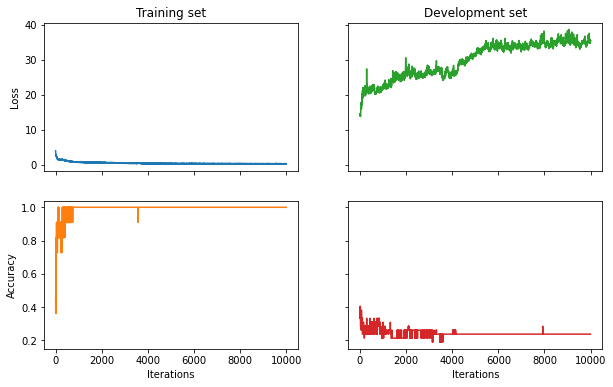

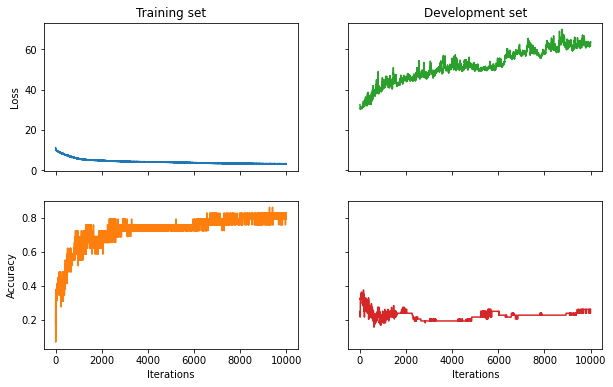

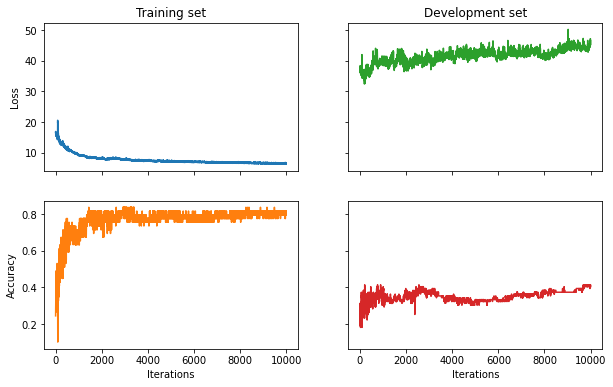

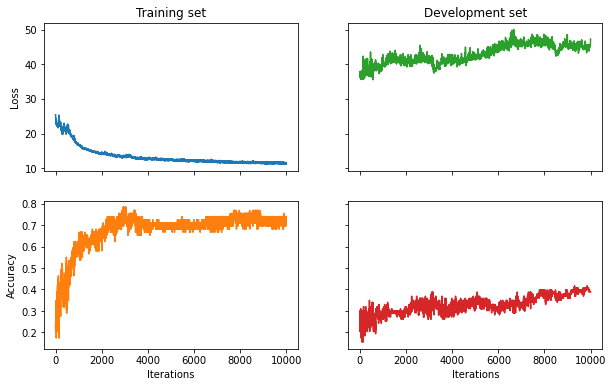

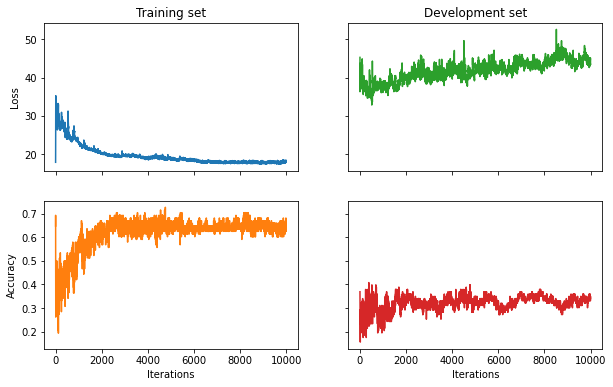

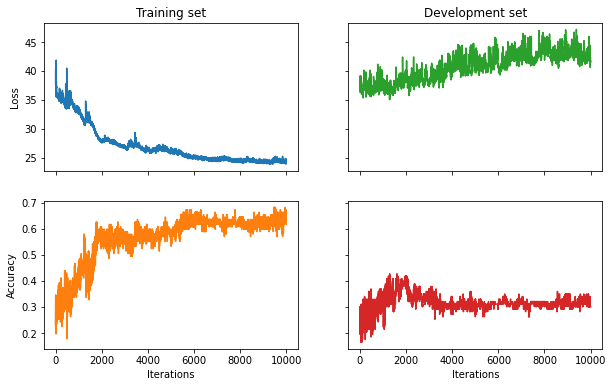

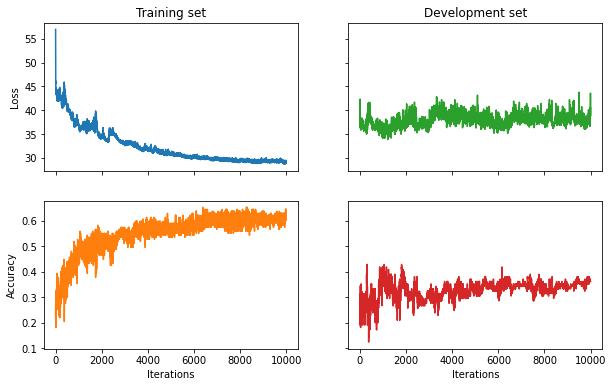

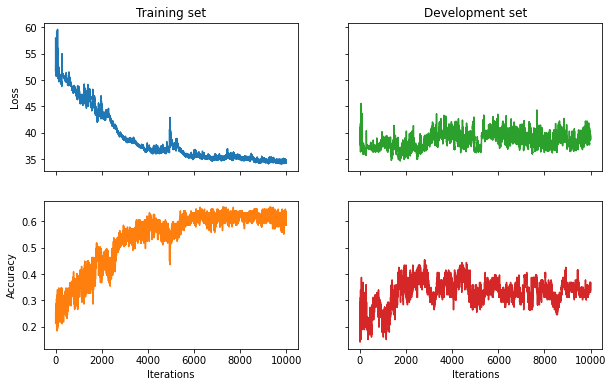

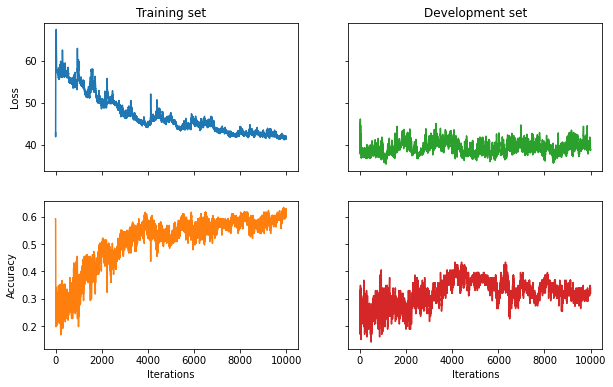

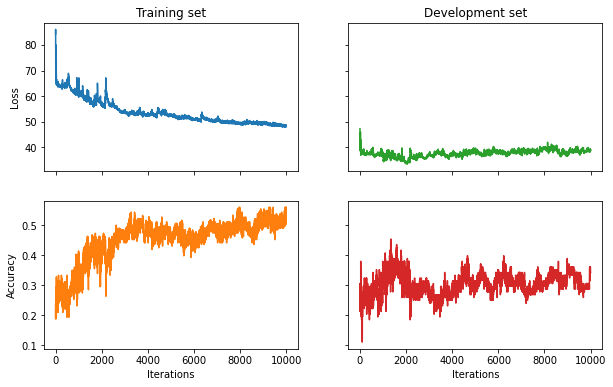

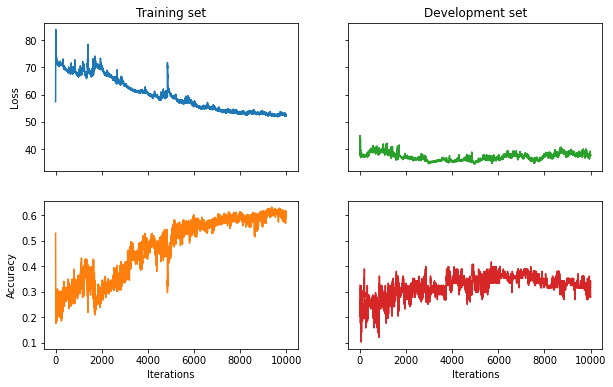

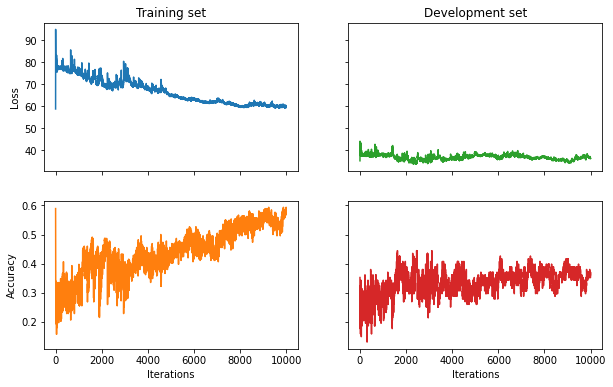

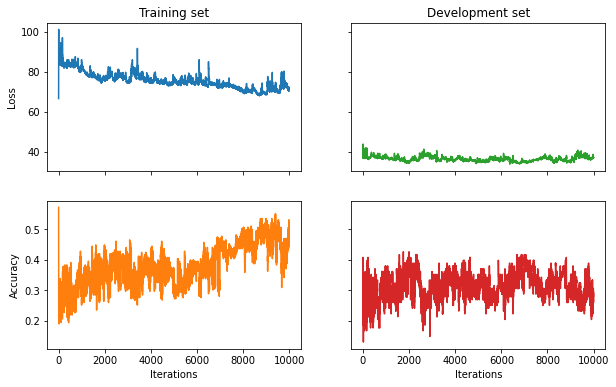

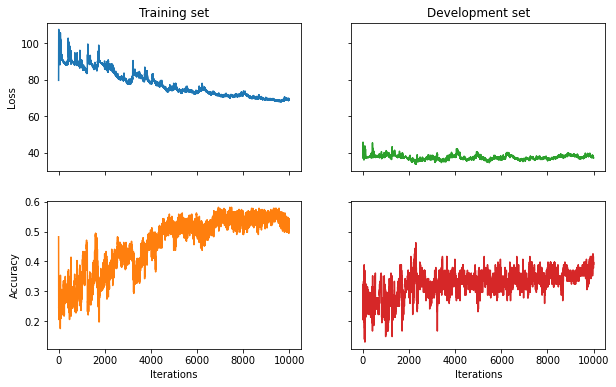

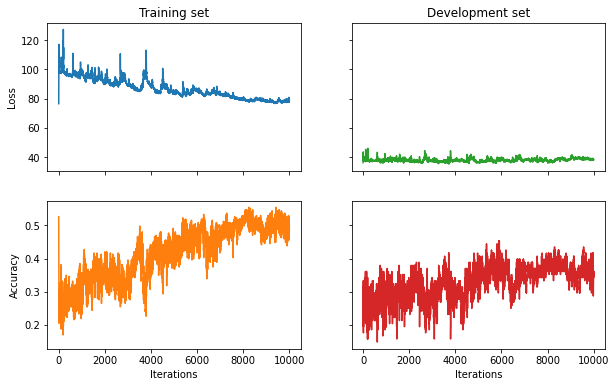

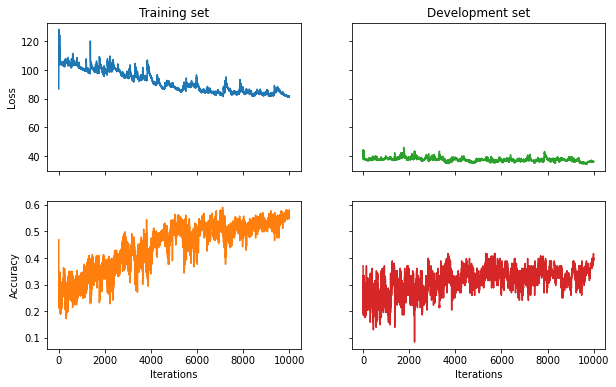

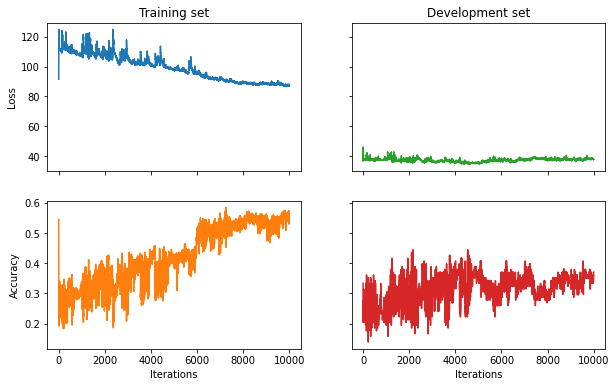

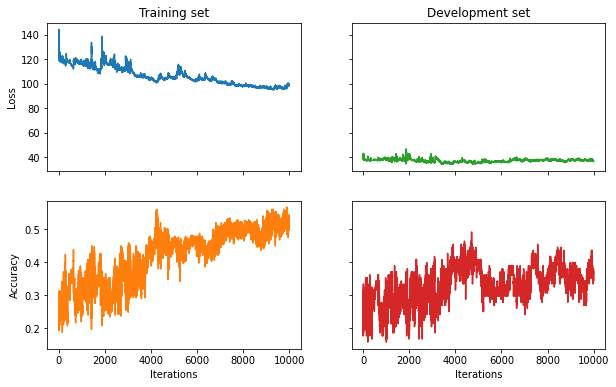

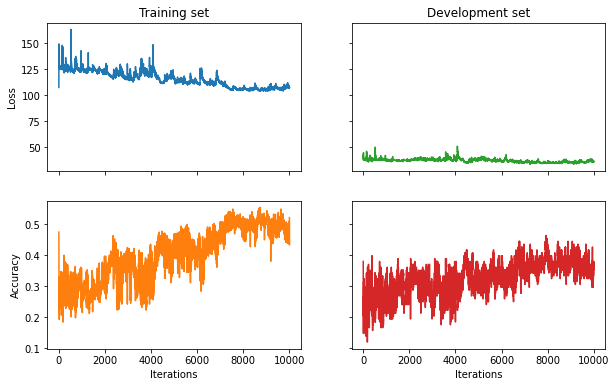

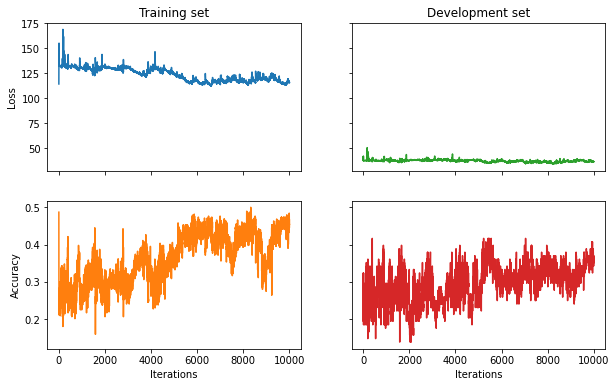

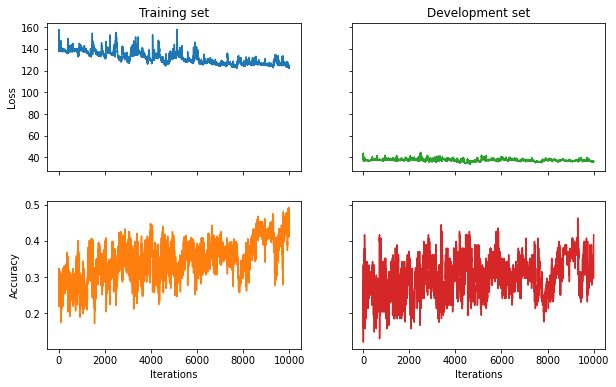

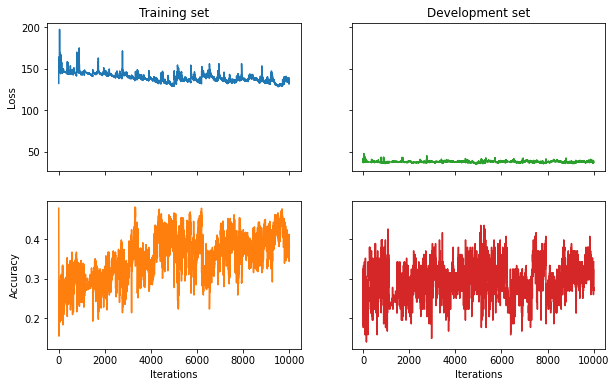

In [9]:
result = None

for i, key in enumerate(all_training_keys[initial_number_of_circuits:]):
    print("Progress: ", round((i + initial_number_of_circuits)/len(all_training_keys), 3))
    
    if len(syms) == len(get_symbols(current_training_circuits)) and i > 0:
        if i != len(all_training_keys[1:]):
            current_training_circuits[key] = training_circuits[key]
            new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
            if result:
                parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)
                #continue
            else:
                syms = get_symbols(current_training_circuits)
                parameters = sorted(syms, key=default_sort_key)
                init_params_spsa = np.array(rng.random(len(parameters)))
    else:
        run += 1
    
    # Select those circuits from test and validation circuits which share the parameters with the current training circuits
    current_validation_circuits = select_circuits(current_training_circuits, validation_circuits)
    current_test_circuits = select_circuits(current_training_circuits, test_circuits)
    
    if len(current_validation_circuits) == 0 or len(current_test_circuits) == 0:
        continue
    
    # Create lists with circuits and their corresponding label
    training_circuits_l, training_data_labels_l = construct_data_and_labels(current_training_circuits, training_data_labels)
    validation_circuits_l, validation_data_labels_l = construct_data_and_labels(current_validation_circuits, validation_data_labels)
    test_circuits_l, test_data_labels_l = construct_data_and_labels(current_test_circuits, test_data_labels)
    
    # Limit the number of validation and test circuits to 20% of number of the training circuits
    if limit:
        val_test_circ_size = ceil(len(current_training_circuits))
        if len(current_validation_circuits) > val_test_circ_size:
            validation_circuits_l = validation_circuits_l[:val_test_circ_size]
            validation_data_labels_l = validation_data_labels_l[:val_test_circ_size]
        if len(current_test_circuits) > val_test_circ_size:
            test_circuits_l = test_circuits_l[:val_test_circ_size]
            test_data_labels_l = test_data_labels_l[:val_test_circ_size]
    
    stats = f"Number of training circuits: {len(training_circuits_l)}   "\
        + f"Number of validation circuits: {len(validation_circuits_l)}   "\
        + f"Number of test circuits: {len(test_circuits_l)}   "\
        + f"Number of parameters in model: {len(set([sym for circuit in training_circuits_l for sym in circuit.free_symbols]))}"
    
    with open("results//" + result_file + ".txt", "a") as f:
        f.write(stats + "\n")
    
    print(stats)
    
    optimization_interval = 20
    
    if result == None or run % optimization_interval == 0:
    
        train_pred_fn = jit(make_pred_fn(training_circuits_l))
        dev_pred_fn = jit(make_pred_fn(validation_circuits_l))
        test_pred_fn = make_pred_fn(test_circuits_l)

        train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
        dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)

        def callback_fn(xk):
            #print(xk)
            valid_loss = dev_cost_fn(xk)
            train_loss = numpy.around(min(float(train_costs[-1]), float(train_costs[-2])), 4)
            train_acc = numpy.around(min(float(train_accs[-1]), float(train_accs[-2])), 4)
            valid_acc = numpy.around(float(dev_accs[-1]), 4)
            iters = int(len(train_accs)/2)
            if iters % 200 == 0:
                info = f"Epoch: {iters}   "\
                + f"train/loss: {train_loss}   "\
                + f"valid/loss: {numpy.around(float(valid_loss), 4)}   "\
                + f"train/acc: {train_acc}   "\
                + f"valid/acc: {valid_acc}"

                with open("results//" + result_file + ".txt", "a") as f:
                    f.write(info + "\n")

                print(info, file=sys.stderr)
            return valid_loss

        #a_value = 0.0053
        #c_value = 0.0185

        # Good
        #a_value = 0.053
        #c_value = 0.00185

        #a_value = 0.0053
        #c_value = 0.00185
        
        a_value = 0.01 
        c_value = 0.01
        
        a_values = [0.1, 0.01, 0.001, 0.0001]
        c_values = [1, 0.1, 0.01, 0.001, 0.0001]
        
        train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
        dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)
        
        #for a_value in a_values:
        #    for c_value in c_values:
        #print(a_value, c_value)
        result = minimizeSPSA(train_cost_fn, x0=init_params_spsa, a = a_value, c = c_value, niter=EPOCHS, callback=callback_fn)
        #result = minimizeCompass(train_cost_fn, x0=init_params_spsa, redfactor=2.0, deltainit=1.0, deltatol=0.001, feps=1e-15, errorcontrol=True, funcNinit=30, funcmultfactor=2.0, paired=True, alpha=0.05, callback=callback_fn)

        figure_path = this_folder + "//results//" + result_file + ".png"
        visualize_result_noisyopt(result, make_cost_fn, test_pred_fn, test_data_labels_l, train_costs, train_accs, dev_costs, dev_accs, figure_path, result_file)
    
    run += 1
    #EPOCHS += 100
    syms = get_symbols(current_training_circuits)
    
    # Extend for the next optimization round
    current_training_circuits[key] = training_circuits[key]
    new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
    parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)